<img src="../../data/images/gempy_logo.png" />

# <center> From Maps to Models - Tutorials for structural geological modeling using GemPy and GemGIS</center>

# Example 3 - Three Point Problem

This example will show how to convert the geological map below using GemGIS to a GemPy model. This example is based on digitized data. The area is 2973 m wide (W-E extent) and 3698 m high (N-S extent). The vertical model extent varies between 0 m and 1000 m. This example represents a classic "three-point-problem" of planar dipping layers (blue and purple) above an unspecified basement. The interface points were not recorded at the surface but rather in boreholes at depth.

<div class="alert alert-block alert-success">
<b>In this tutorial, you will learn the following:</b> <br>
- How to build your 17th GemPy model with input data generated through GemGIS<br>
- How to create models from a three-point-problem
</div>

## Your Tasks


1. Georeference the map in QGIS given the dimensions above using the coordinate reference system with the EPSG code 4326
2. Digitize the layer boundaries (including a `formation` column) and the topographic lines (including a `Z` column)
3. Calculate Orientations from provided points

## Contents

1. [Installing GemPy and GemGIS](#installing-gempy)
2. [Importing Libraries](#importing-libraries)
3. [Data Preparation](#data-preparation)
    1. [Creating Digital Elevation Model from Contour lines](#creating-digital-elevation-model-from-contour-lines)
        1. [Loading Contour Lines](#loading-contour-lines)
        2. [Plotting Contour Lines](#plotting-contour-lines)
        3. [Interpolating Contour Lines](#interpolating-contour-lines)
        4. [Plotting the raster](#plotting-the-raster)
        5. [Saving the raster to disc](#saving-the-raster-to-disc)
        6. [Opening raster](#opening-raster)
    2. [Processing Stratigraphic Boundaries](#processing-stratigraphic-boundaries)
        1. [Opening Stratigraphic Boundaries](#opening-stratigraphic-boundaries)
        2. [Plotting Stratigraphic Boundaries](#plotting-stratigraphic-boundaries)
        3. [Extracting Z coordinates from Digital Elevation Model](#extracting-z-coordinates-from-digital-elevation-model)
        4. [Plotting the Interface Points](#plotting-the-interface-points)
    3. [Processing Orientations](#processing-orientations)
        1. [Orientations from Strike Lines](#orientations-from-strike-lines)
        2. [Plotting Strike Lines](#plotting-strike-lines)
        2. [Loading Strike Lines](#loading-strike-lines)
        3. [Plotting Strike Lines](#plotting-strike-lines)
        4. [Calculate Orientations for each formation](#calculate-orientations-for-each-formation)
        5. [Merging Orientations for GemPy](#merging-orientations-for-gempy)
        6. [Plotting Orientations](#plotting-orientations)
4. [GemPy Model calculation](#gempy-model-calculation)
    1. [Creating the GemPy Model](#creating-the-gempy-model)
    2. [Data Initiation](#data-initiation)
    3. [Inspecting the Surfaces](#inspecting-the-surfaces)
    4. [Inspecting the Input Data](#inspecting-the-input-data)
    5. [Map Stack to Surfaces](#map-stack-to-surfaces)
    6. [Showing the Number of Data Points](#showing-the-number-of-data-points)
    7. [Loading Digital Elevation Model](#loading-digital-elevation-model)
    8. [Defining Custom Section](#defining-custom-section)
    6. [Plotting Input Data in 2D](#plotting-the-input-data-in-2d)
    7. [Plotting Input Data in 3D](#plotting-the-input-data-in-3d)
    8. [Setting the Interpolator](#setting-the-interpolator)
    9. [Computing the Model](#computing-the-model)
5. [Model Visualization and Post-Processing](#model-visualization-and-post-processing)
    1. [Visualizing the computed model in 2D](#visualizing-the-computed-model-in-2d)
    2. [Visualizing the computed model in 3D](#visualizing-the-computed-model-in-3d)    
    
<img src="../../data/images/example14/cover_example14.png" />
Source: Bennison, G.M. (1988): An Introduction to Geological Structures and Maps, page 15, figure 7, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-1-4615-9632-5

<a id='installing-gempy'></a>

# Installing GemPy and GemGIS

If you have not installed `GemPy` yet, please follow the [GemPy installation instructions](https://docs.gempy.org/installation.html) and the [GemGIS installation instructions](https://gemgis.readthedocs.io/en/latest/getting_started/installation.html). If you encounter any issues, feel free to open a new discussion at [GemPy Discussions](https://github.com/cgre-aachen/gempy/discussions) or [GemGIS Discussions](https://github.com/cgre-aachen/gemgis/discussions). If you encounter an error in the installation process, feel free to also open an issue at [GemPy Issues](https://github.com/cgre-aachen/gempy/issues) or [GemGIS Issues](https://github.com/cgre-aachen/gemgis/issues). There, the `GemPy` and `GemGIS` development teams will help you out. 

<a id='importing-libraries'></a>

# Importing Libraries

For this notebook, we need the `geopandas` library for the data preparation, `rasterio` for dealing with the created digital elevation model, `matplotlib` for plotting, `numpy` for some numerical calculations, `pandas` for manipulating `DataFrames` and of course the `gempy` and `gemgis` libraries. Any warnings that may appear can be ignored for now. The file path is set to load the data provided for this tutorial. 

In [1]:
import geopandas as gpd
import rasterio
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg
import matplotlib.pyplot as plt
import numpy as np
import gempy as gp
import pyvista as pv
import pandas as pd

C:\Users\ale93371\AppData\Local\Temp\ipykernel_5440\547675048.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementation

In [2]:
file_path = '../../data/example14_three_point_problem/'

<a id='data-preparation'></a>
# Data Preparation

At his point, you should have the topographic contour lines (including a `Z` column) and the layer boundaries (including a `formation` column) digitized. If not, please generate the data before continuing with this tutorial. 

<a id='creating-digital-elevation-model-from-contour-lines'></a>
## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating the contour lines digitized from the georeferenced map using the `SciPy` [Radial Basis Function interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 


<img src="../../data/images/example14/dem_example14.png" width=700/>
Source: Bennison, G.M. (1988): An Introduction to Geological Structures and Maps, page 15, figure 7, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-1-4615-9632-5


<a id='loading-contour-lines'></a>
### Loading contour lines

First, the contour lines are loaded using `GeoPandas`. Please provide here the name of your shape file containing the digitized topographic contour lines. 

In [3]:
topo = gpd.read_file(file_path + 'topo14.shp')
topo.head()

,id,Z,geometry
0,None,800,"LINESTRING (373.02111 427.16813, 400.17689 396..."
1,None,800,"LINESTRING (1394.65000 431.74174, 1406.65571 4..."
2,None,700,"LINESTRING (3.13085 921.97496, 58.01410 877.95..."
3,None,700,"LINESTRING (263.82630 1502.82273, 293.26888 14..."
4,None,600,"LINESTRING (2110.41909 2231.74093, 2145.29283 ..."


<a id='plotting-contour-lines'></a>

### Plotting the contour lines

The contour lines are plotted using the built-in plotting function of `GeoPandas`. 

<AxesSubplot: >

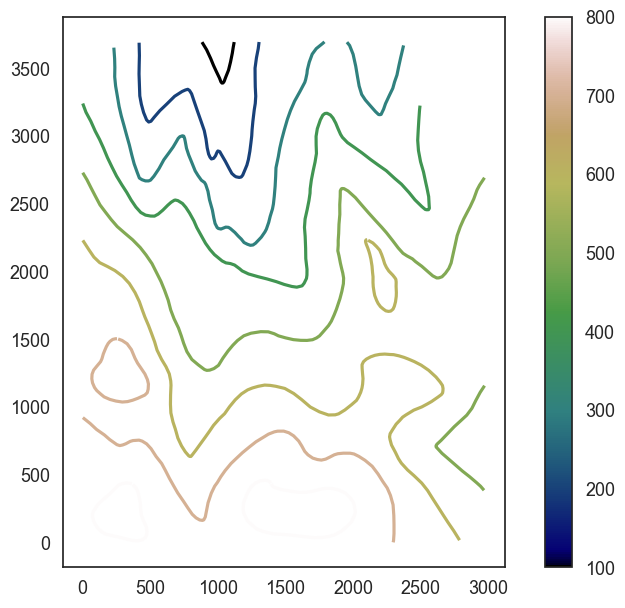

In [4]:
topo.plot(column='Z', aspect=1, legend=True, cmap='gist_earth')

<a id='interpolating-contour-lines'></a>

### Interpolating the contour lines

The digital elevation model (DEM) will be created by interpolating the contour lines digitized from the georeferenced map using the `SciPy` [Radial Basis Function interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

There is also a [tutorial available for this task on the GemGIS Documentation page](https://gemgis.readthedocs.io/en/latest/getting_started/tutorial/05_interpolating_rasters.html)

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=15)

<a id='plotting-the-raster'></a>

### Plotting the raster

The interpolated digital elevation model can be displayed using `matplotlib` and its `plt.imshow()` function and by providing the extent of the raster to align it with the contour lines. 

(0.0, 3698.0)

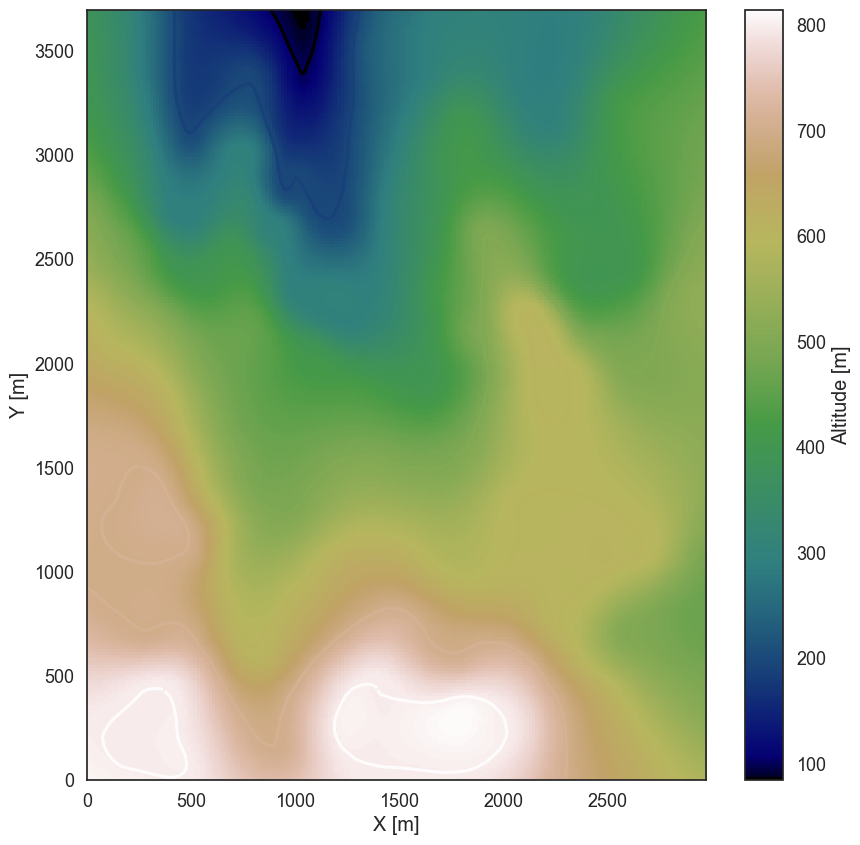

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0, 2973, 0, 3698], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(0, 2973)
ax.set_ylim(0, 3698)

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster14.tif')

<a id='processing-stratigraphic-boundaries'></a>

## Processing Stratigraphic Boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a `formation` name for each layer boundary. Up until now, only the `X` and `Y` position are stored in the vertices of the LineStrings. Using the digital elevation model created already, we will now sample the elevation model at the locations of the vertices to extract the height at this point as the stratigraphic boundary was mapped at the surface.

<img src="../../data/images/example14/interfaces_example14.png" width=700/>
Source: Bennison, G.M. (1988): An Introduction to Geological Structures and Maps, page 15, figure 7, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-1-4615-9632-5

<a id='opening-stratigraphic-boundaries'></a>

### Opening Stratigraphic Boundaries

The stratigraphic units are opened using `GeoPandas`.

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces14.shp')
interfaces.head()

,id,formation,geometry
0,None,Sandstone,"LINESTRING (491.89909 1350.89330, 476.46318 14..."
1,None,Shale,"LINESTRING (986.42007 273.80946, 976.70116 356..."
2,None,Sandstone,"LINESTRING (2137.82499 264.09055, 2168.69682 3..."
3,None,Sandstone,"LINESTRING (2295.61434 934.12360, 2339.63528 9..."
4,None,Shale,"LINESTRING (1190.51717 3118.01972, 1213.95689 ..."


<a id='plotting-stratigraphic-boundaries'></a>

### Plotting Stratigraphic Boundaries

Text(49.05315170940169, 0.5, 'Y [m]')

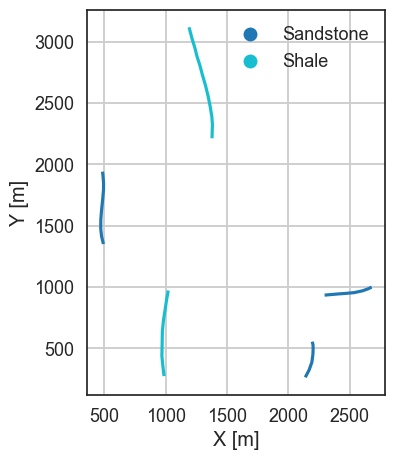

In [9]:
fig, ax = plt.subplots(1, figsize=(5,5))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')

plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

<a id='extracting-z-coordinates-from-digital-elevation-model'></a>

### Extracting Z coordinates from Digital Elevation Model

The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective `formation` as well as the `X`, `Y`, and `Z` location. This is all we need as preparational steps to generate input data for `GemPy`. 

There is also a [tutorial available for this task on the GemGIS Documentation page](https://gemgis.readthedocs.io/en/latest/getting_started/tutorial/02_extract_xyz.html).

In [10]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,Sandstone,POINT (491.89909 1350.89330),491.90,1350.89,663.18
1,Sandstone,POINT (476.46318 1416.06717),476.46,1416.07,656.31
2,Sandstone,POINT (470.17447 1476.09573),470.17,1476.10,643.79
3,Sandstone,POINT (470.74617 1548.70170),470.75,1548.70,625.64
4,Sandstone,POINT (475.89148 1617.30576),475.89,1617.31,607.52


<a id='plotting-the-interface-points'></a>

### Plotting the Interface Points

The interface points incuding their altitude (Z-) values and the digitized LineString can be plotted using `matplotlib`. 

(0.0, 3698.0)

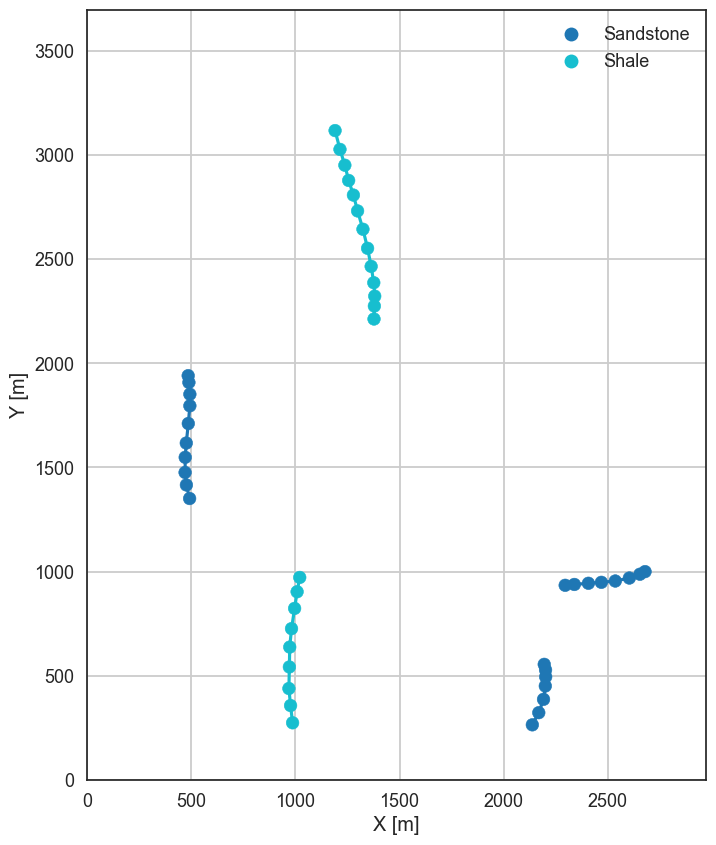

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(0, 2973)
ax.set_ylim(0, 3698)

<a id='processing-orientations'></a>

## Processing Orientations

For this example, orientations must be calculated yourself. They will be calculated using functions implemented in GemGIS and the previously digitized strike lines. 

<img src="../../data/images/example14/orientations_example14.png" width=700/>
Source: Bennison, G.M. (1988): An Introduction to Geological Structures and Maps, page 15, figure 7, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-1-4615-9632-5
<a id='orientations-strike-lines'></a>
### Orientations from Strike Lines

For this three point example, an orientation is calculated using `gg.vector.calculate_orientation_for_three_point_problem()`.


In [12]:
orientations = gpd.read_file(file_path + 'orientations14.shp')
orientations

,id,formation,Z,geometry
0,None,Sandstone,600,POINT (477.32073 1628.59685)
1,None,Sandstone,700,POINT (2201.42668 477.76363)
2,None,Sandstone,600,POINT (2390.08786 942.55618)


In [13]:
orientations = gg.vector.calculate_orientation_for_three_point_problem(gdf=orientations)
orientations

,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,633.33,Sandstone,19.73,11.28,1.00,1689.61,1016.31,POINT (1689.61175 1016.30556)


### Changing the Data Type of Fields

In [14]:
orientations['Z'] = orientations['Z'].astype(float)
orientations['azimuth'] = orientations['azimuth'].astype(float)
orientations['dip'] = orientations['dip'].astype(float)
orientations['dip'] = 180 - orientations['dip']
orientations['azimuth'] = 180 - orientations['azimuth']
orientations['polarity'] = orientations['polarity'].astype(float)
orientations['X'] = orientations['X'].astype(float)
orientations['Y'] = orientations['Y'].astype(float)
orientations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Z          1 non-null      float64 
 1   formation  1 non-null      object  
 2   azimuth    1 non-null      float64 
 3   dip        1 non-null      float64 
 4   polarity   1 non-null      float64 
 5   X          1 non-null      float64 
 6   Y          1 non-null      float64 
 7   geometry   1 non-null      geometry
dtypes: float64(6), geometry(1), object(1)
memory usage: 192.0+ bytes


In [15]:
orientations

,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,633.33,Sandstone,160.27,168.72,1.00,1689.61,1016.31,POINT (1689.61175 1016.30556)


<a id='plotting-the-orientations'></a>

### Plotting the Orientations

The orientations can be plotted using `matplotlib`.

(0.0, 3698.0)

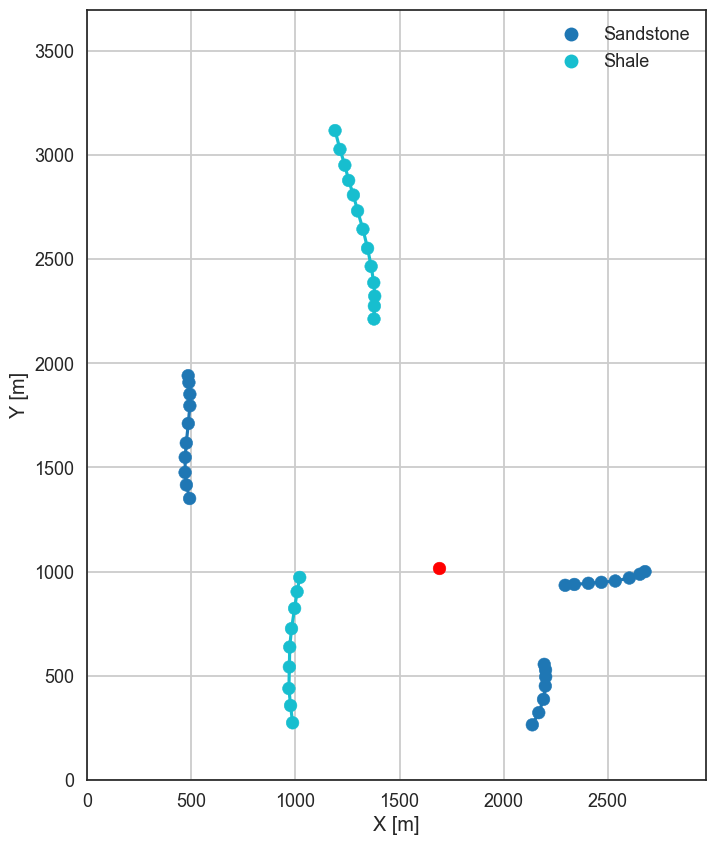

In [16]:
fig, ax = plt.subplots(1, figsize=(10, 10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(0, 2973)
ax.set_ylim(0, 3698)

<a id='gempy-model-calculation'></a>

# GemPy Model Calculation


The creation of a `GemPy` Model follows particular steps which will be performed in the following:

1. Create new model: `gp.create_model()`
2. Data Initiation: `gp.init_data()`
3. Map Stack to Surfaces: `gp.map_stack_to_surfaces()`
4. [...]
5. Set the Interpolator: `gp.set_interpolator()`
6. Computing the Model: `gp.compute_model()`

<a id='creating-the-gempy-model'></a>

## Creating the GemPy Model

The first step is to create a new empty `GemPy` model by providing a name for it. 

In [17]:
geo_model = gp.create_model('Model14')
geo_model

Model14  2023-03-05 17:50

<a id='data-initiation'></a>

## Data Initiation

During this step, the `extent` of the model (`xmin`, `xmax`, `ymin`, `ymax`, `zmin`, `zmax`) and the `resolution` in `X`, `Y`and `Z` direction (`res_x`, `res_y`, `res_z`, equal to the number of cells in each direction) will be set using lists of values. 

The interface points (`surface_points_df`) and orientations (`orientations_df`) will be passed as `pandas` `DataFrames`. 

In [18]:
gp.init_data(geo_model, [0, 2973, 0, 3698, 0, 1000], [100, 100, 100],
             surface_points_df=interfaces_coords[interfaces_coords['Z'] != 0],
             orientations_df=orientations,
             default_values=True)

Active grids: ['regular']


Model14  2023-03-05 17:50

<a id='inspecting-the-surfaces'></a>

## Inspecting the Surfaces

The model consists of five different layers or surfaces now which all belong to the `Default series`. During the next step, the proper `Series` will be assigned to the surfaces. Using the `surfaces`-attribute again, we can check which layers were loaded.

In [19]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Sandstone,Default series,1,#015482,1
1,Shale,Default series,2,#9f0052,2


<a id='inspecting-the-input-data'></a>

## Inspecting the Input Data

The loaded interface points and orientations can again be inspected using the `surface_points`- and `orientations`-attributes. Using the `df`-attribute of this object will convert the displayed table in a `pandas` `DataFrame`.

In [20]:
geo_model.surface_points.df.head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,491.90,1350.89,663.18,0.31,0.44,0.53,Sandstone,Default series,1,1,0.00
1,476.46,1416.07,656.31,0.31,0.45,0.53,Sandstone,Default series,1,1,0.00
2,470.17,1476.10,643.79,0.31,0.46,0.53,Sandstone,Default series,1,1,0.00
3,470.75,1548.70,625.64,0.31,0.48,0.53,Sandstone,Default series,1,1,0.00
4,475.89,1617.31,607.52,0.31,0.49,0.52,Sandstone,Default series,1,1,0.00


In [21]:
geo_model.orientations.df.head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,1689.61,1016.31,633.33,0.52,0.38,0.53,0.07,-0.18,-0.98,168.72,160.27,1.00,Sandstone,Default series,1,1,0.01


<a id='map-stack-to-surfaces'></a>

## Map Stack to Surfaces

During this step, all the layers of the model is assigned to the `Strata1` series. We will also add a `Basement` here (`geo_model.add_surfaces('Basement')`). 

In [22]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Sandstone', 'Shale'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Conglomerate')

,surface,series,order_surfaces,color,id
0,Sandstone,Strata1,1,#015482,1
1,Shale,Strata1,2,#9f0052,2
2,Conglomerate,Strata1,3,#ffbe00,3


<a id='showing-the-number-of-data-points'></a>

## Showing the Number of Data Points

You can also return the number of interfaces and orientations for each formation using `gg.utils.show_number_of_data_points()`

In [23]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,Sandstone,Strata1,1,False,False,True,True,#015482,NaN,NaN,NaN,1,25,1
1,Shale,Strata1,2,False,False,True,True,#9f0052,NaN,NaN,NaN,2,22,0
2,Conglomerate,Strata1,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3,0,0


<a id='loading-digital-elevation-model'></a>

## Loading Digital Elevation Model

`GemPy` is capable of including a topography into the modeling process. Here, we use the topography that we have interpolated in one of the previous steps. `GemPy` takes the file path of the raster/digital elevation model and loads it as grid into the `geo_model` object.

In [24]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster14.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  14.865     ,   18.49      ,    5.        ],
       [  14.865     ,   18.49      ,   15.        ],
       [  14.865     ,   18.49      ,   25.        ],
       ...,
       [2965.49242424, 3660.5708502 ,  428.21966553],
       [2965.49242424, 3675.54251012,  427.20385742],
       [2965.49242424, 3690.51417004,  426.23760986]])

<a id='plotting-the-input-data-in-2d'></a>

## Plotting the input data in 2D using Matplotlib

The input data can now be visualized in 2D using `matplotlib`. This might for example be useful to check if all points and measurements are defined the way we want them to. Using the function `plot_2d()`, we attain a 2D projection of our data points onto a plane of chosen direction (we can choose this attribute to be either `'x'`, `'y'`, or `'z'`).

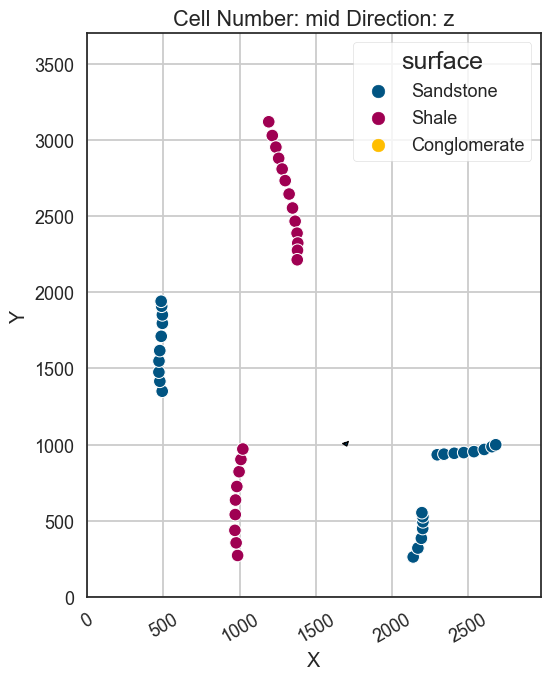

In [25]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

<a id='plotting-the-input-data-in-3d'></a>

## Plotting the input data in 3D using PyVista

The input data can also be viszualized using the `pyvista` package. In this view, the interface points are visible as well as the orientations (marked as arrows) which indicate the normals of each orientation value. 

The `pyvista` package requires the Visualization Toolkit (VTK) to be installed.

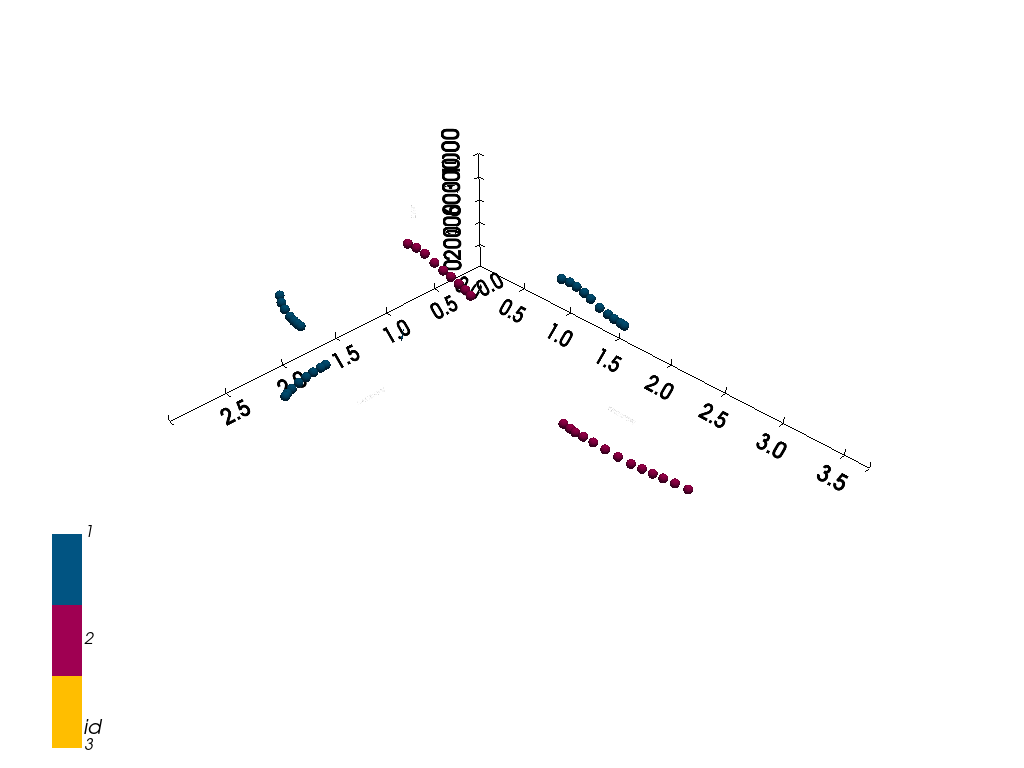

In [26]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

<a id='setting-the-interpolator'></a>
## Setting the interpolator

Once we have made sure that we have defined all our primary information, we can continue with the next step towards creating our geological model: preparing the input data for interpolation.

Setting the interpolator is necessary before computing the actual model. Here, the most important kriging parameters can be defined. 

In [27]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             4849.12
$C_o$           559855.55
drift equations       [3]


<a id='computing-the-model'></a>

## Computing the model

At this point, we have all we need to compute our full model via `gp.compute_model()`. By default, this will return two separate solutions in the form of arrays. The first provides information on the lithological formations, the second on the fault network in the model, which is not present in this example. 

In [ ]:
sol = gp.compute_model(geo_model, compute_mesh=True)

In [ ]:
sol

In [ ]:
geo_model.solutions

<a id='model-visualization-and-post-processing'></a>

# Model Visualization and Post-Processing

<a id='visualizing-cross-sections-of-the-computed-model'></a>

## Visulazing Cross Sections of the computed model

Cross sections in different `direction`s and at different `cell_number`s can be displayed. Here, we see the horizontal layers in the one direction and the faulted layers in the other direction.

In [ ]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 75, 25, 75], show_topography=True, show_data=False)

Next to the lithology data, we can also plot the calculated scalar field.

In [ ]:
gp.plot_2d(geo_model, direction='x', show_data=False, show_scalar=True, show_lith=False)

<a id='visualizing-the-computed-model-in-3d'></a>

# Visualizing the computed model in 3D

The computed model can be visualized in 3D using the `pyvista` library. Setting `notebook=False` will open an interactive windows and the model can be rotated and zooming is possible. 

In [ ]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

<a id='conclusions'></a>
# Conclusions

<div class="alert alert-block alert-success">
<b>In this tutorial, you have learnt the following:</b> <br>
- How to build your 18th GemPy model with input data generated through GemGIS<br>
- How to create models from a three-point-problem
</div>

<a id='outlook'></a>
# Outlook

<div class="alert alert-block alert-success">
<b>In the next tutorial, you will learn the following:</b> <br>
You are now a master in creating structural geological models with <b>GemPy</b> and <b>GemGIS</b>
</div>


<a id='licensing'></a>

## Licensing

Institute for Computational Geoscience, Geothermics and Reservoir Geophysics, RWTH Aachen University & Fraunhofer IEG, Fraunhofer Research Institution for Energy Infrastructures and Geothermal Systems IEG, Authors: Alexander Juestel. For more information contact: alexander.juestel(at)ieg.fraunhofer.de

All notebooks are licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0, http://creativecommons.org/licenses/by/4.0/). References for each displayed map are provided. Most of the maps originate from the books of [Powell (1992)](https://link.springer.com/book/9783540586074) and [Bennison (1990)](https://link.springer.com/book/10.1007/978-1-4615-9630-1). References for maps with unknown origin will gladly be added.